# Determinare se una donna impieghi parte del suo tempo in relazioni extramatimoniali

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Lorenzo Bartolini

## Parte 1 - Descrizione del problema e analisi esplorativa

Si deve realizzare un modello che, utilizzando i dati raccolti da un sondaggio del 1974 della rivista "Redbook" da un campione di 6366 donne, sia in grado di prevedere se una donna impieghi o meno tempo in relazioni extramatrimoniali.

Istruiamo Python a nascondere i warning relativi alla convergenza e alla deprecazione

In [4]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Si importano le librerie necessarie per organizzare le strutture dati,  disegnare i grafici e addestrare i modelli

In [5]:
%matplotlib inline
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.pipeline import  Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.under_sampling import RandomUnderSampler

In [6]:
with open("Affairs.csv") as f:
    data = pd.read_csv(f)

In [7]:
data.head()

,Unnamed: 0,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


Rimuoviamo la colonna ridondante "Unnamed: 0"

In [8]:
data.drop(columns="Unnamed: 0", inplace=True)

### Significato delle feature

Riportiamo le informazioni sul dataset dalla [fonte](https://www.kaggle.com/akashadesai/extramarital-affairs-dataset/tasks?taskId=1660)

Il dataset contiene 6366 istanze di 9 variabili:

- `rate_marriage`: valutazione da parte della donna del proprio matrimonio (1 = molto negativo, 5 = molto positivo)
- `age`: età della donna
- `yrs_married`: numero di anni di matrimonio
- `children`: numero di figli
- `religious`: valutazione da parte della donna della propria religiosità (1 = non religiosa, 4 = molto religiosa)
- `educ`: livello d'educazione della donna (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)
- `occupation`: lavoro della donna (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)
- `occupation_husb`: lavoro del marito (stessi significati che sopra)
- `affairs`: tempo impiegato in relazioni extramatrimoniali

Alcune variabili, nonostante la loro forma numerica, sono più facilmente interpretabili come variabili categoriche.

Inseriamo i nomi di queste colonne in un array da utilizzare in seguito.

In [9]:
categorical_vars = ["occupation", "occupation_husb", "educ"]

Andiamo ad analizzare le varie feature nel loro insieme, tramite il metodo `describe`

In [10]:
data.describe()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.705374
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,2.203374
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.484848
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,57.599991


Osservazioni:
- In media le donne valutano molto positivamente il proprio matrimonio
- L'età media delle donne che hanno partecipato al sondaggio era sui 30 anni, e non ci sono donne con età superiore al 42
- Nel sondaggio sono inclusi matrimoni di durata molto diversa, avendo `years_married` media e deviazione standard molto simili
- In media ogni donna ha almeno un figlio dal matrimonio corrente
- Le donne incluse nel sondaggio non si reputano eccessivamente religiose
- Le variabili `occupation` possono essere interpretate come "avanzamento di carriera". In tal caso si può notare come in media il marito abbia una carriera più avanzata, con però una deviazione standard più elevata.

### Esplorazione di feature e correlazioni

Verifichiamo per prima cosa quante donne dichiarino di impiegare del tempo in relazioni extramatrimoniali

In [11]:
has_had_affairs = data["affairs"]>0

has_had_affairs.value_counts(), has_had_affairs.mean()

(False    4313
 True     2053
 Name: affairs, dtype: int64, 0.3224945020420987)

Possiamo notare che poco meno di un terzo delle donne dichiarino di utilizzare del tempo in relazioni extramatrimoniali. Sarà necessario prendere accorgimenti per limitare l'impatto di questo sbilanciamento fra le classi.
Disegnamone il grafico

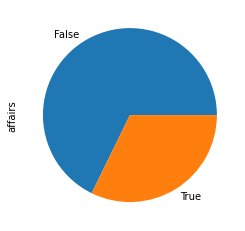

In [12]:
has_had_affairs.value_counts().plot.pie();

Controlliamo la possibile presenza di errori nei dati:

In [13]:
(data["age"] - data["yrs_married"]).describe()

count    6366.000000
mean       20.073437
std         3.278352
min         9.000000
25%        19.000000
50%        19.500000
75%        21.000000
max        39.500000
dtype: float64

Valutiamo le possibili correlazioni fra i dati:

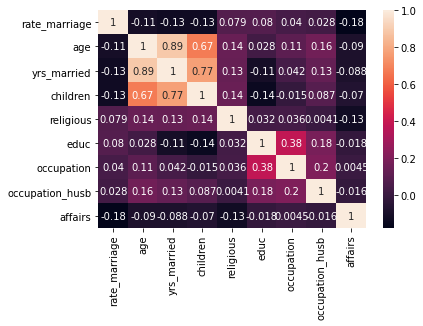

In [14]:
sb.heatmap(data.corr(method='pearson'), annot=True);

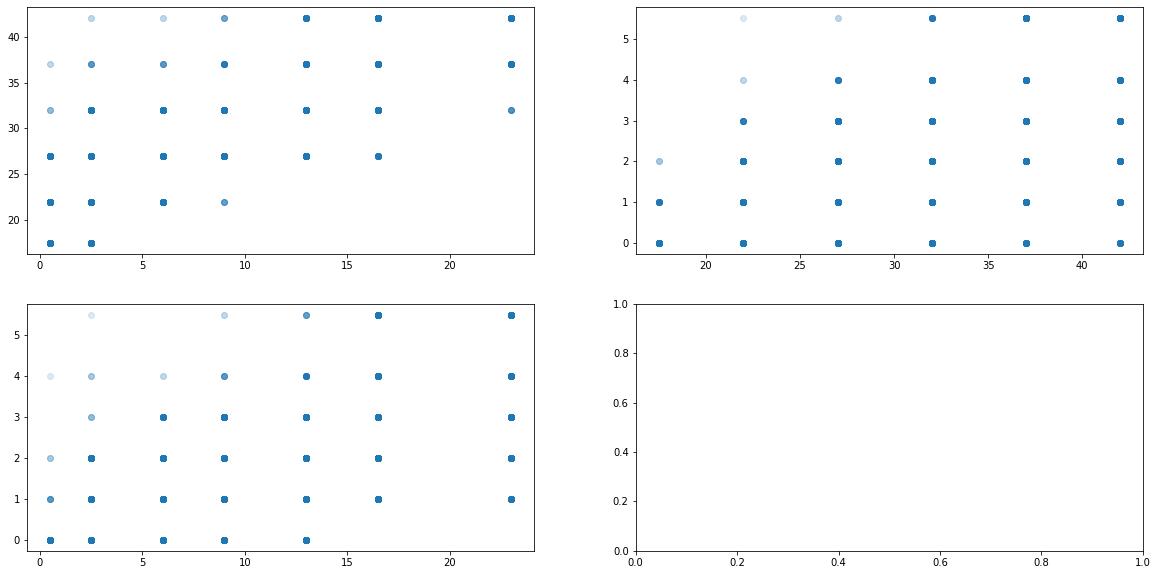

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axes[0,0].scatter(data["yrs_married"],data["age"],alpha=.15)
axes[0,1].scatter(data["age"],data["children"],alpha=.15);
axes[1,0].scatter(data["yrs_married"],data["children"],alpha=.15);

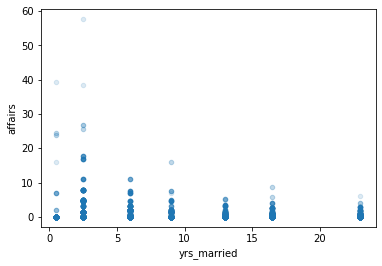

In [16]:
data.plot.scatter("yrs_married", "affairs", alpha=.15);

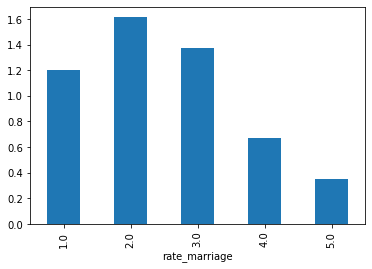

In [17]:
data.groupby("rate_marriage").mean()["affairs"].plot.bar();

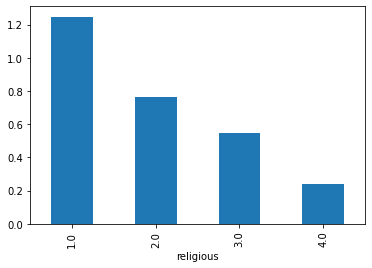

In [18]:
data.groupby("religious").mean()["affairs"].plot.bar();

Osservazioni:
- Come aspettato, età, durata del matrimonio e numero di figli tendono a crescere insieme
- Pù il matrimonio è longevo, meno è probabile che la donna impieghi una quantità considerevole del suo tempo in relazioni extramatrimoniali
- Più il matrimonio è valutato negativamente, più è probabile che la donna impieghi una quantità considerevole del suo tempo in relazioni extramatrimoniali
- Più la donna è religiosa, meno è probabile che la donna impieghi una quantità considerevole del suo tempo in relazioni extramatrimoniali

## Parte 2 - Feature preprocessing

Trasformiamo i dati categorici in stringhe per rendere più chiara poi l'interpretazione dei risultati, e istruiamo Pandas a trattarli come dati categorici per diminuire l'uso di risorse

In [19]:
def make_categorical(data, col, dict):
    data[col] = data[col].map(lambda x: dict[x])
    data[col] = data[col].astype("category")

In [20]:
occ_dict = {
    1:"student",
    2:"unskilled",
    3:"white collar",
    4:"skilled",
    5:"business",
    6:"advanced"
}

make_categorical(data, "occupation", occ_dict)
make_categorical(data, "occupation_husb", occ_dict)

In [21]:
educ_dict = {
    9:"grade school",
    12:"high school",
    14:"college",
    16:"college grad",
    17:"grad school",
    20:"advanced"
}

make_categorical(data,"educ",educ_dict)

In [22]:
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,grad school,unskilled,business,0.111111
1,3.0,27.0,13.0,3.0,1.0,college,white collar,skilled,3.230769
2,4.0,22.0,2.5,0.0,1.0,college grad,white collar,business,1.400000
3,4.0,37.0,16.5,4.0,3.0,college grad,business,business,0.727273
4,5.0,27.0,9.0,1.0,1.0,college,white collar,skilled,4.666666


In [23]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   rate_marriage    6366 non-null   float64 
 1   age              6366 non-null   float64 
 2   yrs_married      6366 non-null   float64 
 3   children         6366 non-null   float64 
 4   religious        6366 non-null   float64 
 5   educ             6366 non-null   category
 6   occupation       6366 non-null   category
 7   occupation_husb  6366 non-null   category
 8   affairs          6366 non-null   float64 
dtypes: category(3), float64(6)
memory usage: 318.8 KB


Dividiamo la variabile da predirre dalle altri variabili del dataset.
La variabile da predirre viene trasformata in una variabile booleana in base ad una semplice regola: se il tempo speso in relazioni extramatrimoniali è maggiore di zero.

In [24]:
X = data.drop(columns="affairs")
y = data["affairs"] > 0

In [25]:
y.value_counts(), y.mean()

(False    4313
 True     2053
 Name: affairs, dtype: int64, 0.3224945020420987)

La distribuzione delle due classi da predirre è 32% si, 68% no

Dividiamo i dati in due parti, utilizzando la funzione di sklearn `train_test_split`

In [26]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=1/3, random_state=1337)

Facciamo un test preliminare con l'algoritmo perceptron, e visualizziamone la score.  
Le variabili categoriche vengono preprocessate con un OneHotEncoder

Per sopperire allo sbilanciamento delle classi, il modello Perceptron ci offre l'argomento `class_weight`, che se impostato su `"balanced"` permette di allenare il modello pesando in modo maggiore la classe meno popolata

In [27]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("categorical", OneHotEncoder(), categorical_vars)
    ], remainder="passthrough")),
    ("perc",  Perceptron(n_jobs=-1, random_state=1337, class_weight="balanced"))
])
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5339302544769086

Verifichiamo quali sono le variabili che più influiscono nella decisione

In [28]:
enc = OneHotEncoder()
enc.fit_transform(X[categorical_vars])
index = enc.get_feature_names().tolist()
numeric_vars = [el for el in X.columns if el not in categorical_vars]
index.extend(numeric_vars)
index

['x0_advanced',
 'x0_business',
 'x0_skilled',
 'x0_student',
 'x0_unskilled',
 'x0_white collar',
 'x1_advanced',
 'x1_business',
 'x1_skilled',
 'x1_student',
 'x1_unskilled',
 'x1_white collar',
 'x2_advanced',
 'x2_college',
 'x2_college grad',
 'x2_grad school',
 'x2_grade school',
 'x2_high school',
 'rate_marriage',
 'age',
 'yrs_married',
 'children',
 'religious']

In [29]:
pd.Series(model.named_steps["perc"].coef_[0], index=index).sort_values()

rate_marriage     -243.662157
religious         -138.008299
x0_student           4.331120
x2_advanced          4.419412
children             9.562550
age                 13.136500
x0_unskilled        18.632271
x1_student          31.977193
yrs_married         38.560828
x2_grade school     58.997732
x0_skilled          66.872836
x1_business         73.054876
x2_grad school      77.809797
x1_unskilled        84.269555
x2_college grad     86.869083
x1_advanced         99.231022
x1_skilled         112.000175
x0_advanced        128.686277
x0_white collar    133.901922
x2_high school     158.240526
x1_white collar    174.718474
x2_college         188.914745
x0_business        222.826869
dtype: float64

Sapendo che x0->occupation, x1->occupation_husb, x2->education:

Possiamo osservare che le feature più incisive in negativo (ossia verso l'assenza di relazioni extramatrimoniali) sono la valutazione del matrimonio da parte della donna e quanto questa si consideri religiosa. La feature più incisiva in positivo, ossia verso la presenza di relazioni extramatrimoniali, sembra essere legata al lavoro della donna, in particolare se la donna ha posizione manageriale.

Si può procedere alla standardizzazione delle feature non categoriche, per provare a migliorare la score

In [30]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("categorical", OneHotEncoder(), categorical_vars)
    ], remainder=StandardScaler())),
    ("perc",  Perceptron(n_jobs=-1, random_state=1337, class_weight="balanced"))
])
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6126295947219604

In [31]:
pd.Series(model.named_steps["perc"].coef_[0], index=index).sort_values()

x2_grad school    -3.029216
rate_marriage     -2.507850
x1_advanced       -1.921553
x0_skilled        -1.805971
x1_student        -1.756207
x2_advanced       -1.149400
x0_business       -0.875963
religious         -0.861962
x1_business       -0.460723
x0_unskilled      -0.392765
x0_student        -0.128425
x2_grade school    0.117187
x1_unskilled       0.463934
x2_college grad    0.790882
x0_advanced        1.305650
yrs_married        1.416504
age                1.610926
x2_college         1.691994
x1_skilled         1.698951
x2_high school     1.732127
x0_white collar    2.051048
x1_white collar    2.129173
children           4.945196
dtype: float64

Lo score è lievemente migliorato, e i pesi si sono allineati.

Per individuare quali variabili non sono necessarie per la predizione della classe, si può utilizzare una penalizzazione l1

In [32]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("categorical", OneHotEncoder(), categorical_vars)
    ], remainder=StandardScaler())),
    ("perc",  Perceptron(n_jobs=-1, penalty="l1", random_state=1337, class_weight="balanced"))
])
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.4472196041470311

In [33]:
pd.Series(model.named_steps["perc"].coef_[0], index=index).sort_values()

rate_marriage     -2.087443
age               -1.877264
religious         -1.794002
x1_student        -1.111421
x0_student        -0.958917
children          -0.537475
x2_high school     0.000000
x2_grade school    0.000000
x2_grad school     0.000000
x2_college grad    0.000000
x2_college         0.000000
x2_advanced        0.000000
x0_advanced        0.000000
x1_skilled         0.000000
x1_business        0.000000
x1_advanced        0.000000
x0_white collar    0.000000
x0_unskilled       0.000000
x0_skilled         0.000000
x1_unskilled       0.000000
x0_business        1.129615
x1_white collar    2.543891
yrs_married        2.680638
dtype: float64

La penalizzazione l1 va ad annullare il peso di molte feature, andando più che a dimezzare il numero di feature prese in considerazione

##Parte 3: modellazione

In [34]:
skf = StratifiedKFold(3, shuffle=True, random_state=1337)

Come primo valutiamo un modello basato su Perceptron, simile a quello utilizzato nella scorsa parte. Anche qui utilizziamo l'argomento `class_weight`, che verrà impostato su `"balanced"` anche nei prossimi modello ove possibile

In [35]:
perc_pipeline = Pipeline([
    ("preproc", ColumnTransformer([
        ("categorical", OneHotEncoder(), categorical_vars),
    ])),
    ("perc", Perceptron(n_jobs=-1, random_state=1337, class_weight="balanced"))
])

grid = {
    "preproc__remainder": ["passthrough", StandardScaler()],
    "perc__penalty": [None,"l2", "l1", "elasticnet"],
    "perc__alpha": np.logspace(-4, 3, 8),
}
perc_model = GridSearchCV(perc_pipeline, grid, cv=skf)
perc_model.fit(X_train, y_train)

perc_model.score(X_test,y_test), perc_model.best_params_

(0.5188501413760603,
 {'perc__alpha': 0.0001,
  'perc__penalty': 'l2',
  'preproc__remainder': 'passthrough'})

La regressione logistica è un modello basato sulla regressione lineare

In [36]:
logreg_pipeline = Pipeline([
    ("preproc", ColumnTransformer([
        ("categorical", OneHotEncoder(), categorical_vars),
    ])),
    ("logreg",  LogisticRegression(solver="saga", random_state=1337, class_weight="balanced"))
])

grid = [
        {
            "preproc__remainder": ["passthrough", StandardScaler()],
            "logreg__C": np.logspace(-4, 2, 7),
            "logreg__penalty": ["l2", "l1"],
        },
        {
            "preproc__remainder": ["passthrough", StandardScaler()],
            "logreg__C": np.logspace(-4, 2, 7),
            "logreg__penalty": ["elasticnet"],
            "logreg__l1_ratio": [0.2, 0.5]
        }
]

logreg_model = GridSearchCV(logreg_pipeline, grid, cv=skf)
logreg_model.fit(X_train, y_train)
logreg_model.score(X_test,y_test), logreg_model.best_params_

(0.6950989632422243,
 {'logreg__C': 0.001,
  'logreg__l1_ratio': 0.2,
  'logreg__penalty': 'elasticnet',
  'preproc__remainder': StandardScaler(copy=True, with_mean=True, with_std=True)})

Il modello a Support Vector Machines ci permette di utilizzare una funzione kernel per effettuare una classificazione non lineare

In [37]:
svc_pipeline = Pipeline([
    ("preproc", ColumnTransformer([
        ("categorical", OneHotEncoder(), categorical_vars),
    ])),
    ("svc",SVC(random_state=1337, class_weight="balanced"))
])

grid = {
  "preproc__remainder": ["passthrough", StandardScaler()],
  "svc__kernel": ["poly","linear"],
  "svc__degree": [1,2,3],
}

svc_model = GridSearchCV(svc_pipeline, grid, cv=skf)
svc_model.fit(X_train, y_train)
svc_model.score(X_test,y_test), svc_model.best_params_

(0.6922714420358153,
 {'preproc__remainder': 'passthrough',
  'svc__degree': 3,
  'svc__kernel': 'poly'})

Un modello basato su alberi decisionali prevede la classe basandosi su decisioni sulle singole variabili

In [38]:
tree_pipeline = Pipeline([
    ("preproc", ColumnTransformer([
        ("categorical", OneHotEncoder(), categorical_vars)
    ])),
    ("tree", DecisionTreeClassifier(random_state=1337, class_weight="balanced"))
])

grid = {
          "preproc__remainder": ["passthrough", StandardScaler()],
          "tree__min_samples_split": [5, 2, 0.02, 0.05, 0.1],
          "tree__max_depth": [i for i in range(2, 7)],
        }

tree_model = GridSearchCV(tree_pipeline, grid, cv=skf)
tree_model.fit(X_train, y_train)
tree_model.score(X_test,y_test), tree_model.best_params_


(0.6621112158341188,
 {'preproc__remainder': 'passthrough',
  'tree__max_depth': 4,
  'tree__min_samples_split': 0.1})

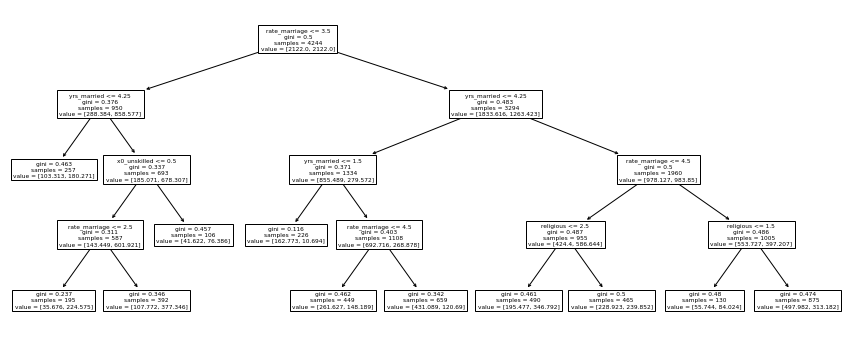

In [39]:
plt.figure(figsize=(15, 6))
plot_tree(tree_model.best_estimator_.named_steps["tree"], feature_names=index);

Un Multi-layer Perceptron è una versione a più strati del Perceptron, in cui si può introdurre non-linearità attraverso la funzione di attivazione. In questo caso utilizziamo la funzione ReLU

Siccome questo modello non supporta l'attributo `class_weight`, ne testiamo due varianti: una utilizzando lo stesso sample che abbiamo fornito agli altri modelli, e una in cui abbiamo applicato undersampling al dataset, andando a rimuovere alcune istanze appartenenti alla classe più popolata

In [40]:
mlpc_pipeline = Pipeline([
    ("preproc", ColumnTransformer([
        ("categorical", OneHotEncoder(), categorical_vars)
    ], remainder=StandardScaler())),
    ("mlp", MLPClassifier(activation="relu", max_iter=1000, random_state=1337))
])

grid = {
    "mlp__hidden_layer_sizes": [8, 16, (16, 8)],
    "mlp__batch_size": [100, 200, 300],
}

mlpc_model = GridSearchCV(mlpc_pipeline, grid, cv=skf)
mlpc_model.fit(X_train, y_train)
mlpc_model.score(X_test,y_test), mlpc_model.best_params_

(0.7191328934967012, {'mlp__batch_size': 300, 'mlp__hidden_layer_sizes': 8})

In [41]:
rus = RandomUnderSampler(random_state=1337)
X_train_under_np, y_train_under_np = rus.fit_sample(X_train, y_train)
X_train_under = pd.DataFrame(X_train_under_np, columns=X_train.columns)
y_train_under = pd.Series(y_train_under_np)

y_train_under.value_counts(), len(X_train_under)

(True     1389
 False    1389
 dtype: int64, 2778)

In [42]:
mlpc_model_under = GridSearchCV(mlpc_pipeline, grid, cv=skf)
mlpc_model_under.fit(X_train_under, y_train_under)
mlpc_model_under.score(X_test,y_test), mlpc_model.best_params_

(0.672478793590952, {'mlp__batch_size': 300, 'mlp__hidden_layer_sizes': 8})

## Parte 4 - Valutazione dei modelli di classificazione

Si importano e librerie necessarie e si definisce una funzione che stampi la confusion matrix del modello, insieme alle metriche di valutazione più importanti.

In [43]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [44]:
def display_model_metrics(model, X, y):
    y_pred = model.predict(X)
    
    conf_matrix = pd.DataFrame(confusion_matrix(y, y_pred))
    precision = precision_score(y, y_pred, zero_division=0, pos_label=1)
    recall = recall_score(y, y_pred)
    f1 =  f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    
    print(f"""{conf_matrix}\n\n \
Precision:  {precision}\n \
   Recall:  {recall}\n \
 F1 Score:  {f1}\n \
 Accuracy:  {accuracy}\n""")

In [45]:
for model, name in [
              (perc_model,"Perceptron"),
              (logreg_model,"Logistic Regression"),
              (svc_model,"Support Vector"),
              (tree_model,"Tree"),
              (mlpc_model,"MLP Full"),
              (mlpc_model_under,"MLP Under")
              ]:
  print(name+"\n")
  display_model_metrics(model, X_test, y_test)

Perceptron

     0    1
0  500  958
1   63  601

 Precision:  0.3855035279025016
    Recall:  0.9051204819277109
  F1 Score:  0.540710751237067
  Accuracy:  0.5188501413760603

Logistic Regression

      0    1
0  1064  394
1   253  411

 Precision:  0.5105590062111801
    Recall:  0.6189759036144579
  F1 Score:  0.5595643294758339
  Accuracy:  0.6950989632422243

Support Vector

      0    1
0  1082  376
1   277  387

 Precision:  0.5072083879423329
    Recall:  0.5828313253012049
  F1 Score:  0.54239663629993
  Accuracy:  0.6922714420358153

Tree

     0    1
0  918  540
1  177  487

 Precision:  0.4741966893865628
    Recall:  0.733433734939759
  F1 Score:  0.5759905381431105
  Accuracy:  0.6621112158341188

MLP Full

      0    1
0  1244  214
1   382  282

 Precision:  0.5685483870967742
    Recall:  0.4246987951807229
  F1 Score:  0.48620689655172417
  Accuracy:  0.7191328934967012

MLP Under

     0    1
0  971  487
1  208  456

 Precision:  0.4835630965005302
    Recall:  0.6867

Si riescono ad individuare tre gruppi di modelli:
1. il gruppo costituito dal Perceptron
2. il gruppo costituito dal modello basato su MLP senza undersampling
3. il gruppo costituito dai modelli su cui è stato applicato il bilanciamento delle classi o l'undersampling, cioè tutti gli altri

Il gruppo peggiore è senza dubbio quello del Perceptron, che nonostante abbia un punteggio F1 allineato con quelli del secondo gruppo, ha un'accuratezza di gran lunga inferiore.

Il modello ad MPL senza undersampling presenta il singolo pungeggio d'accuratezza migliore, ma soffre notevolmente nel punteggio F1.

Fra i proponenti del terzo gruppo non c'è molta differenza, ma si delinea come vincitore il modello a MLP con undersampling, che presenta il punteggio F1 più alto.



###Confronto fra i modelli con intervallo di confidenza
Confrontiamo fra di loro i modelli, calcolando con confidenza al 95% se le differenze fra i punteggi F1 sono statisticamente significative.

In [46]:
def calculate_model_difference(model1, model2, confidence):
  error1 = f1_score(y_test, model1.predict(X_test))
  error2 = f1_score(y_test, model2.predict(X_test))
  z_ha = stats.norm.ppf(confidence)
  variance = (((1 - error1) * error1) / len(y_test)) + (((1 - error2) * error2) / len(y_test))
  center = abs(error1 - error2)
  delta = z_ha * (variance ** 0.5)
  print(f"Intervallo: [{center - delta} {center + delta}]\nCentro: {center}\nDelta: {delta}\n")

In [47]:
print("Intervallo fra logreg e tree")
calculate_model_difference(logreg_model, tree_model, .95)
print("Intervallo fra svc e mlp con undersampling")
calculate_model_difference(svc_model, mlpc_model_under, .95)
print("Intervallo fra svc e tree")
calculate_model_difference(svc_model, tree_model, .95)
print("Intervallo fra svg e logreg")
calculate_model_difference(svc_model, logreg_model, .95)
print("Intervallo fra tree e mlp con undersampling")
calculate_model_difference(tree_model, mlpc_model_under, .95)
print("Intervallo fra logreg e mlp con undersampling")
calculate_model_difference(logreg_model, mlpc_model_under, .95)

print("Intervallo fra mlp con e senza undersampling")
calculate_model_difference(mlpc_model, mlpc_model_under, .95)

Intervallo fra logreg e tree
Intervallo: [-0.008586035045455982 0.04143845238000922]
Centro: 0.01642620866727662
Delta: 0.025012243712732602

Intervallo fra svc e mlp con undersampling
Intervallo: [3.273964183582098e-05 0.05020821302277233]
Centro: 0.025120476332304076
Delta: 0.025087736690468255

Intervallo fra svc e tree
Intervallo: [0.008537083724547059 0.05865071996181406]
Centro: 0.03359390184318056
Delta: 0.025056818118633504

Intervallo fra svg e logreg
Intervallo: [-0.007945711797372725 0.04228109814918061]
Centro: 0.017167693175903942
Delta: 0.025113404973276666

Intervallo fra tree e mlp con undersampling
Intervallo: [-0.01651304599759388 0.03345989701934685]
Centro: 0.008473425510876487
Delta: 0.024986471508470366

Intervallo fra logreg e mlp con undersampling
Intervallo: [-0.017090434160173196 0.032996000472973464]
Centro: 0.007952783156400134
Delta: 0.02504321731657333

Intervallo fra mlp con e senza undersampling
Intervallo: [0.05618167176826373 0.106438760392756]
Centro:

L'intervallo di confidenza ci mostra che la differenza di punteggio F1 fra i modelli del gruppo 3 non è statisticamente significativa. È invece significativa la differenza fra i due modelli MLP


##Parte 5: Analisi dei modelli migliori

###Confronto con un modello casuale
Attraverso il `DummyClassifier` di sklearn, possiamo simulare un modello con la stessa distribuzione di predizioni rispetto ad un modello reale.

Confrontiamolo con i modelli addestrati

In [48]:
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier()
dummy_model.fit(X_train,y_train)

print("Dummy model metrics:")
display_model_metrics(dummy_model, X_test, y_test)

calculate_model_difference(dummy_model, logreg_model, .99)
calculate_model_difference(dummy_model, tree_model, .99)
calculate_model_difference(dummy_model, svc_model, .99)
calculate_model_difference(dummy_model, mlpc_model_under, .99)
calculate_model_difference(dummy_model, mlpc_model, .99)

Dummy model metrics:
     0    1
0  979  479
1  463  201

 Precision:  0.29558823529411765
    Recall:  0.30271084337349397
  F1 Score:  0.29910714285714285
  Accuracy:  0.5560791705937794

Intervallo: [0.21481816199559037 0.28336098678275423]
Centro: 0.24908957438917229
Delta: 0.03427141239358192

Intervallo: [0.23064827464365797 0.29904409558422357]
Centro: 0.26484618511394076
Delta: 0.03419791047028279

Intervallo: [0.17093735139254615 0.24029609845989866]
Centro: 0.2056167249262224
Delta: 0.03467937353367626

Intervallo: [0.23686404706817346 0.3049249505898336]
Centro: 0.2708944988290035
Delta: 0.03403045176083006

Intervallo: [0.11619224672964301 0.1856333110796876]
Centro: 0.1509127789046653
Delta: 0.034720532175022294



Tutti i modelli individuati hanno una differenza di f1-score rispetto al modello casuale statisticamente rilevante con confidenza al 99%

## Parte 6: Conclusione

Avendo ottenuto una schiera di modelli fra di loro comparabili, si trova difficile dare una sentenza su quale sia il migliore.
Ipotizzando diverse applicazioni di questi modelli, si vanno a delineare scelte diverse in base a quale siano le necessità di predizione.  
Se la volontà è quella di abbassare al minimo la frequenza di falsi positivi, il modello MLP senza undersampling potrebbe essere la scelta migliore, grazie alla più alta `precision`. Se la volontà è invece quella di classificare il numero maggiore di casi positivi come tali, i modelli del terzo gruppo potrebbero essere la scelta migliore date le più alte `recall`.